In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import joblib
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import (accuracy_score , precision_score, recall_score,f1_score,
roc_auc_score,classification_report,confusion_matrix,RocCurveDisplay)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import time


In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/lung_cancer/prep_dataset.csv")

In [3]:
df.head()

,id,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived
0,1,64.0,1,0,1,3,29.4,199,0,0,1,0,0,0
1,2,50.0,0,2,1,3,41.2,280,1,1,0,0,3,1
2,3,65.0,0,2,1,1,44.0,268,1,1,0,0,1,0
3,4,51.0,0,0,0,3,43.0,241,1,1,0,0,0,0
4,5,37.0,1,0,0,3,19.7,178,0,0,0,0,1,0


In [16]:
df['survived'].value_counts()

,count
survived,
0,693996
1,196004


In [4]:
X = df.drop(['id','survived'],axis=1)
y= df['survived']

In [5]:
X_train ,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
print("Training Shape:",X_train.shape,y_train.shape)
print("Testing Shape:",X_test.shape,y_test.shape)

Training Shape: (712000, 12) (712000,)
Testing Shape: (178000, 12) (178000,)


In [6]:
X_train

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type
814810,44.0,1,3,0,0,43.8,264,1,1,0,0,0
615281,62.0,1,3,0,3,35.2,298,1,0,0,0,3
557577,56.0,1,1,1,3,22.6,211,0,1,0,0,2
269028,66.0,0,1,1,1,22.2,210,1,0,0,0,0
28244,70.0,1,0,1,3,25.5,166,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
183143,37.0,0,1,0,1,32.6,278,1,0,0,1,3
716281,56.0,0,0,1,2,32.6,242,1,1,1,0,1
622544,53.0,0,0,1,2,23.8,163,1,0,0,0,1
37422,42.0,0,1,1,0,23.7,190,1,1,1,0,0


In [19]:
xgb_model = xgb.XGBClassifier(
    tree_method="gpu_hist", predictor="gpu_predictor", random_state=42
)

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model, xgb_param_grid, n_iter=10, cv=3,
    scoring="accuracy", n_jobs=-1, verbose=1, random_state=42
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
xgb_model = xgb.XGBClassifier(
    tree_method="gpu_hist", predictor="gpu_predictor", random_state=42
)

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model, xgb_param_grid, n_iter=10, cv=3,
    scoring="accuracy", n_jobs=-1, verbose=1, random_state=42
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


# Random_Forst and XGBBoost

In [17]:
start = time.time()
rf = RandomForestClassifier(
    n_estimators=100, max_depth=10, n_jobs=-1, random_state=42,class_weight='balanced',
)
rf.fit(X_train, y_train)
end = time.time()

y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("\n🌲 Random Forest Results")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Training Time: %.2f sec" % (end - start))



🌲 Random Forest Results
Train Accuracy: 0.5831474719101124
Test Accuracy: 0.5329662921348315
Training Time: 41.17 sec


In [18]:
start = time.time()
xgb_model = xgb.XGBClassifier(
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train)
end = time.time()

y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)

print("\n⚡ XGBoost Results")
print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Training Time: %.2f sec" % (end - start))


⚡ XGBoost Results
Train Accuracy: 0.6081418539325842
Test Accuracy: 0.530061797752809
Training Time: 2.21 sec



📊 XGBoost Evaluation
Accuracy : 0.7797696629213483
Precision: 0.6080407272124732
Recall   : 0.7797696629213483
F1 Score : 0.6832802467420682

Classification Report:
               precision    recall  f1-score   support

           0       0.78      1.00      0.88    138799
           1       0.00      0.00      0.00     39201

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000



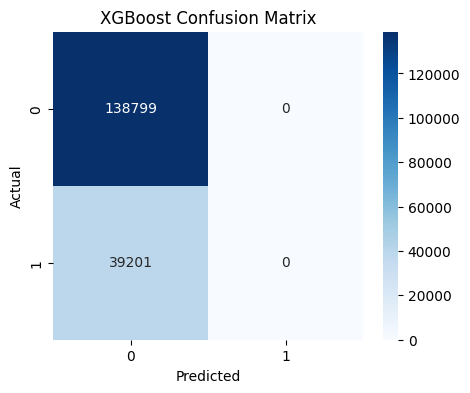

In [20]:

# Choose best models
# best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Predictions
# rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)

# =============================
# 1. Evaluation Function
# =============================
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 {name} Evaluation")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall   :", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score :", f1_score(y_true, y_pred, average='weighted'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# =============================
# 2. Evaluate Both Models
# =============================
# evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)

# Applying smote on training **data**



In [23]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before Smote:",y_train.value_counts())
print("After Smote:",y_train_res.value_counts())

Before Smote: survived
0    555197
1    156803
Name: count, dtype: int64
After Smote: survived
0    555197
1    555197
Name: count, dtype: int64


In [26]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)

y_train_pred_rf = rf.predict(X_train_res)
y_test_pred_rf = rf.predict(X_test)

print("Random Forest Metrics:")
print("Train Classification Report:\n", classification_report(y_train_res, y_train_pred_rf))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred_rf))
print("Test ROC-AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))



Random Forest Metrics:
Train Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    555197
           1       1.00      1.00      1.00    555197

    accuracy                           1.00   1110394
   macro avg       1.00      1.00      1.00   1110394
weighted avg       1.00      1.00      1.00   1110394

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77    138799
           1       0.22      0.24      0.23     39201

    accuracy                           0.64    178000
   macro avg       0.50      0.50      0.50    178000
weighted avg       0.66      0.64      0.65    178000

Test ROC-AUC: 0.4975768009410477


In [27]:
# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)

y_train_pred_xgb = xgb_model.predict(X_train_res)
y_test_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost Metrics:")
print("Train Classification Report:\n", classification_report(y_train_res, y_train_pred_xgb))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred_xgb))
print("Test ROC-AUC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:,1]))


XGBoost Metrics:
Train Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.75      0.70    555197
           1       0.71      0.60      0.65    555197

    accuracy                           0.68   1110394
   macro avg       0.68      0.68      0.68   1110394
weighted avg       0.68      0.68      0.68   1110394

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76    138799
           1       0.22      0.25      0.24     39201

    accuracy                           0.64    178000
   macro avg       0.50      0.50      0.50    178000
weighted avg       0.66      0.64      0.65    178000

Test ROC-AUC: 0.4998231188277782


In [31]:
train_acc = accuracy_score(y_train_res, y_train_pred_xgb)
test_acc = accuracy_score(y_test, y_test_pred_rf)

In [ ]:
print("Train Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

# **Train XGboost and hyperparamter tuning **

In [30]:
xgb_model = xgb.XGBClassifier(
    tree_method="gpu_hist", predictor="gpu_predictor", random_state=42
)

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model, xgb_param_grid, n_iter=10, cv=3,
    scoring="accuracy", n_jobs=-1, verbose=1, random_state=42
)
xgb_search.fit(X_train_res, y_train_res)
best_xgb = xgb_search.best_estimator_
xgb_model = xgb.XGBClassifier(
    tree_method="gpu_hist", predictor="gpu_predictor", random_state=42
)

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model, xgb_param_grid, n_iter=10, cv=3,
    scoring="accuracy", n_jobs=-1, verbose=1, random_state=42
)
xgb_search.fit(X_train_res, y_train_res)
best_xgb = xgb_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits



📊 XGBoost Evaluation
Accuracy : 0.6435786516853933
Precision: 0.6572136278704701
Recall   : 0.6435786516853933
F1 Score : 0.6501026667651854

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77    138799
           1       0.22      0.25      0.23     39201

    accuracy                           0.64    178000
   macro avg       0.50      0.50      0.50    178000
weighted avg       0.66      0.64      0.65    178000



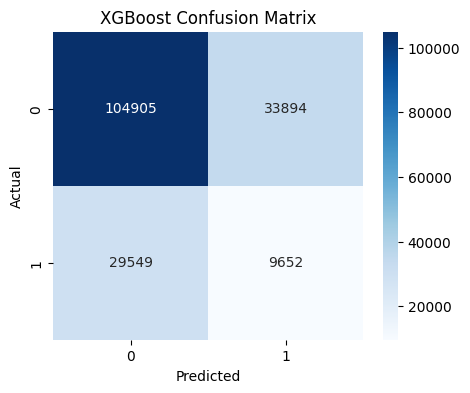

In [33]:

# Choose best models
# best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

# Predictions
# rf_pred = best_rf.predict(X_test)
xgb_pred = best_xgb.predict(X_test)

# =============================
# 1. Evaluation Function
# =============================
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 {name} Evaluation")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall   :", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score :", f1_score(y_true, y_pred, average='weighted'))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# =============================
# 2. Evaluate Both Models
# =============================
# evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("XGBoost", y_test, xgb_pred)

# **Save the Model and Load**

In [34]:
joblib.dump(best_xgb,'lung_cancer_xgbmodel.pkl')
print("model saved sucessfully!")

model saved sucessfully!


In [36]:
# loaded_moedl = joblib.load('lung_cancer_xgbmodel.pkl')
# predictions = loaded_moedl.predict(X_test)